# Python - Week 6 - Day 2 - CS
## Shahin Mammadov

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler   
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as mp
import seaborn as sb
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from datetime import datetime
import time

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [2]:
data = pd.read_csv('nasa.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

In [4]:
data.isna().sum().sum()

0

In [5]:
data[data.duplicated()]

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous


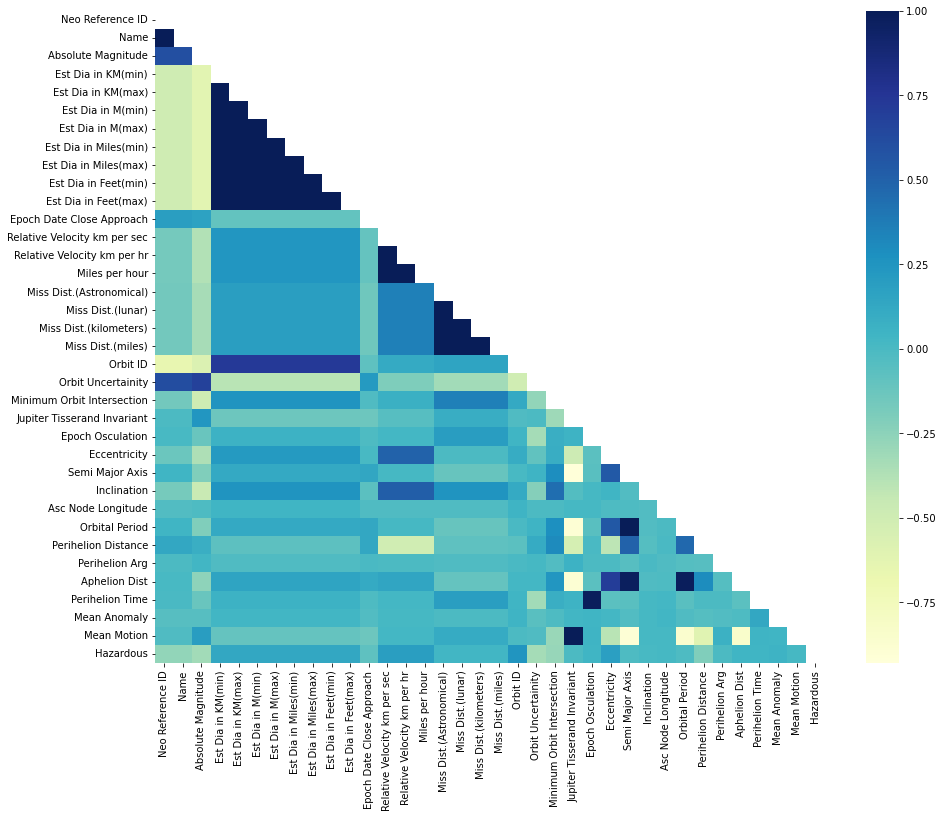

In [6]:
mp.rcParams["figure.figsize"] = [15, 12]

mask = np.triu(np.ones_like(data.corr()))
 
# plotting a triangle correlation heatmap
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", mask=mask)
 
# displaying heatmap
mp.show()

In [7]:
data.drop(columns=['Name', 'Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Miss Dist.(lunar)', 'Miss Dist.(miles)', 'Miss Dist.(Astronomical)', 'Relative Velocity km per hr', 'Miles per hour', 'Neo Reference ID', 'Orbit Determination Date', 'Close Approach Date', 'Orbiting Body', 'Equinox'], inplace=True)

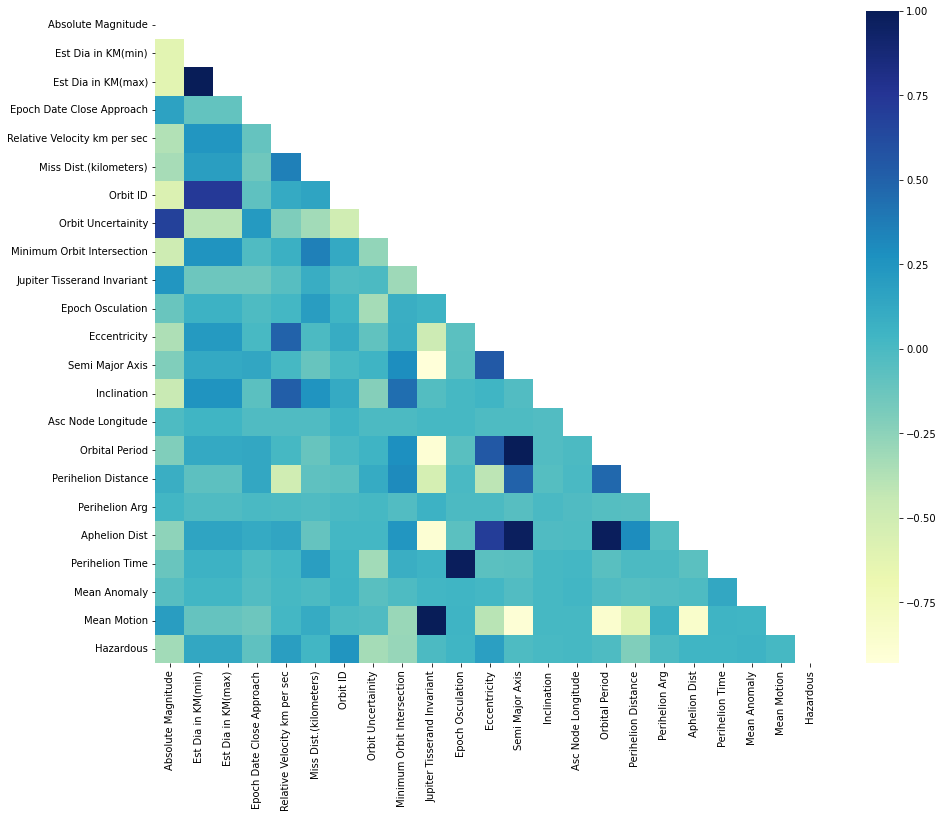

In [8]:
mp.rcParams["figure.figsize"] = [15, 12]

mask = np.triu(np.ones_like(data.corr()))
 
# plotting a triangle correlation heatmap
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", mask=mask)
 
# displaying heatmap
mp.show()

In [9]:
data[data.duplicated()]

,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Epoch Date Close Approach,Relative Velocity km per sec,Miss Dist.(kilometers),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,...,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous


In [10]:
X = data.drop('Hazardous', axis=1)
y = data['Hazardous']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

st_x= RobustScaler()    
X_train= st_x.fit_transform(X_train)    
X_test= st_x.transform(X_test) 

## Training with XGBoost

In [12]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
start_time = timer(None) # timing starts from this point for "start_time" variable
pred_xgb = XGB.predict(X_test)
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 0 minutes and 0.0 seconds.


In [13]:
metrics.accuracy_score(y_test, pred_xgb)

0.9957356076759062

In [14]:
metrics.confusion_matrix(y_test, pred_xgb)

array([[1172,    1],
       [   5,  229]], dtype=int64)

In [15]:
print(metrics.classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1173
        True       1.00      0.98      0.99       234

    accuracy                           1.00      1407
   macro avg       1.00      0.99      0.99      1407
weighted avg       1.00      1.00      1.00      1407



## Training with Bayesian Optimization

In [16]:
params = {
        'learning_rate': [0.1, 0.2, 0.4, 0.8, 1.5],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
XGB2 = XGBClassifier()

In [17]:
opt = BayesSearchCV(XGB2, params, n_iter=32, random_state=0)
start_time = timer(None) # timing starts from this point for "start_time" variable
opt.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 1 minutes and 36.19 seconds.


In [18]:
opt.best_score_

0.9970135600394127

In [19]:
opt.best_params_

OrderedDict([('colsample_bytree', 0.6),
             ('gamma', 0.5),
             ('learning_rate', 0.4),
             ('max_depth', 3),
             ('min_child_weight', 1),
             ('subsample', 1.0)])

In [20]:
XGB_boosted = XGBClassifier(colsample_bytree= 0.6,
                            gamma= 1.5,
                            learning_rate= 1.5,
                            max_depth= 4,
                            min_child_weight= 1,
                            subsample= 1.0)
XGB_boosted.fit(X_train, y_train)
pred_boost = XGB_boosted.predict(X_test)

In [21]:
metrics.accuracy_score(y_test, pred_boost)

0.9985785358919688

In [22]:
metrics.confusion_matrix(y_test, pred_boost)

array([[1173,    0],
       [   2,  232]], dtype=int64)

In [23]:
print(metrics.classification_report(y_test, pred_boost))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1173
        True       1.00      0.99      1.00       234

    accuracy                           1.00      1407
   macro avg       1.00      1.00      1.00      1407
weighted avg       1.00      1.00      1.00      1407



## Training with Randomized Search

In [24]:
params = {
        'learning_rate': [0.1, 0.2, 0.4, 0.8, 1.5],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
XGB3 = XGBClassifier()

In [25]:
XGB_randomized = RandomizedSearchCV(estimator=XGB3,param_distributions=params,
                            scoring='accuracy',
                            cv=10,
                            n_iter=10,
                            return_train_score=True,
                            n_jobs=-1,)

start_time = timer(None) # timing starts from this point for "start_time" variable
XGB_randomized.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 0 minutes and 23.79 seconds.
